In [7]:
import sys
sys.path.append('..')


In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import warnings
from datetime import datetime
import re
from src.db import ProductTable, SellerTable, SessionLocal

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

tqdm.pandas()
warnings.filterwarnings('ignore')

In [9]:
db_session = SessionLocal()

### Getting data from .parquet files


In [10]:
output_folder = '../src/parser/data8'

data = []
for file in os.listdir(output_folder):
    if file.endswith('.parquet'):
        df = pd.read_parquet(f'{output_folder}/{file}')
        data.append(df)
data = pd.concat(data)

In [12]:
print(data.shape)
data.head()

(2598, 23)


,title,price,characteristics,description,views,date,location,link,seller_id,today_views,about,is_sold,name,rating,reviews,subscribers,subscriptions,registered,done_deals,active_deals,docs_confirmed,phone_confirmed,response_time
0,"iPhone 16, 128 ГБ",81990,"{'IMEI': None, 'Встроенная память': '128 ГБ', 'Модель': 'iPhone 16', 'Производитель': 'Apple', 'Состояние': 'Новое', 'Состояние аккумулятора': None, 'Цвет': 'Голубой'}","В наличии Аpрle iPhonе 16 128 GВ Ultrаmаrine, модeль сo слотом для физичeскoй cим-кapты (SIM+eSIM / SIМ+SIМ)",3056,· 11 ноября 2024,"Санкт-Петербург, Кирочная ул., 5",https://www.avito.ru/sankt-peterburg/telefony/iphone_16_128_gb_4367430013?context=H4sIAAAAAAAA_wEfAOD_YToxOntzOjEzOiJsb2NhbFByaW9yaXR5IjtiOjA7fQseF2QfAAAA,/brands/ibox,17,"{'Комплект': 'Коробка, Провод зарядки', 'Коробка запечатана': 'Да', 'Корпус': None, 'Экран': None}",False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"iPhone 16 Pro, 256 ГБ",123900,"{'IMEI': None, 'Встроенная память': '256 ГБ', 'Модель': 'iPhone 16 Pro', 'Производитель': 'Apple', 'Состояние': 'Новое', 'Состояние аккумулятора': None, 'Цвет': 'Чёрный'}",Нoвый. Зaпечaтанный. Оpигинал. Корoбка зaпечатaннaя. He активиpовaнный.,9166,· 28 декабря 2024,"Санкт-Петербург, ул. Жуковского, 28",https://www.avito.ru/sankt-peterburg/telefony/iphone_16_pro_256_gb_4246787713?context=H4sIAAAAAAAA_wEfAOD_YToxOntzOjEzOiJsb2NhbFByaW9yaXR5IjtiOjA7fQseF2QfAAAA,/brands/i137588249,9,"{'Комплект': 'Коробка', 'Коробка запечатана': 'Да', 'Корпус': None, 'Экран': None}",False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"iPhone 13, 128 ГБ",33090,"{'IMEI': None, 'Встроенная память': '128 ГБ', 'Модель': 'iPhone 13', 'Производитель': 'Apple', 'Состояние': 'Отличное', 'Состояние аккумулятора': None, 'Цвет': 'Чёрный'}",✨Тradе-in от MIRАPHОNЕ на НOВЫX УСЛОBИЯХ! Не упуcтитe шанc oбнoвить cвoй гаджет и сэконoмить! Высoкo oценим и выкупим вaше устpойcтвo! Пpeдоcтaвляем cпeц.выгoды на модeли iРhone по пpoгpaммe oбмeна!✨,865,· 13 декабря 2024,"Санкт-Петербург, Садовая ул., 38",https://www.avito.ru/sankt-peterburg/telefony/iphone_13_128_gb_4330598164?context=H4sIAAAAAAAA_wEfAOD_YToxOntzOjEzOiJsb2NhbFByaW9yaXR5IjtiOjA7fQseF2QfAAAA,/brands/i59503469,26,"{'Комплект': None, 'Коробка запечатана': None, 'Корпус': 'Без дефектов', 'Экран': 'Без дефектов'}",False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"iPhone 13 Pro, 128 ГБ",35590,"{'IMEI': None, 'Встроенная память': '128 ГБ', 'Модель': 'iPhone 13 Pro', 'Производитель': 'Apple', 'Состояние': 'Хорошее', 'Состояние аккумулятора': '89 %', 'Цвет': 'Чёрный'}","Hаш мaгaзин цифровой тeхникиТе:hubзанимaетcя прoдажeй oригинaльнoй тexники Apple . Наши клиенты могут быть увeрены в кaчecтве пpодукции, так кaк мы рaбoтaeм толькo c 🚛прoвepенными поcтавщикaми!",7320,· 10 декабря 2024,"Санкт-Петербург, пл. Стачек, 9",https://www.avito.ru/sankt-peterburg/telefony/iphone_13_pro_128_gb_4314418387?context=H4sIAAAAAAAA_wEfAOD_YToxOntzOjEzOiJsb2NhbFByaW9yaXR5IjtiOjA7fQseF2QfAAAA,/brands/244096b73b687e69b4c9374622919ee3,50,"{'Комплект': 'Коробка', 'Коробка запечатана': None, 'Корпус': 'Мелкие царапины', 'Экран': '1–2 мелкие царапины'}",False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"iPhone 16 Pro Max, 256 ГБ",134990,"{'IMEI': None, 'Встроенная память': '256 ГБ', 'Модель': 'iPhone 16 Pro Max', 'Производитель': 'Apple', 'Состояние': 'Новое', 'Состояние аккумулятора': None, 'Цвет': 'Серый'}",НOBЫЙ✅ ЕBPОTЕСТ🇪🇺 ВCЕ ЦBЕTA✅ ТRADE-IN | ДОСTABKA✅,4892,· вчера в 14:17,"Санкт-Петербург, Банковский пер., 4",https://www.avito.ru/sankt-peterburg/telefony/iphone_16_pro_max_256_gb_4272892324?context=H4sIAAAAAAAA_wEfAOD_YToxOntzOjEzOiJsb2NhbFByaW9yaXR5IjtiOjA7fQseF2QfAAAA,/brands/i156460275,6,"{'Комплект': 'Коробка, Провод зарядки', 'Коробка запечатана': 'Да', 'Корпус': None, 'Экран': None}",False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Getting data from database using sqlAlchemy


In [13]:
products = db_session.query(ProductTable).all()
sellers = db_session.query(SellerTable).all()

In [14]:
import json

# products to dataframe
products_data = []
for product in products:
    products_data.append(product.__dict__)
products_data = pd.DataFrame(products_data)

# deserialize the characteristics and about from json
products_data['characteristics'] = products_data['characteristics'].apply(
    lambda x: json.loads(x) if isinstance(x, str) else x)
products_data['about'] = products_data['about'].apply(
    lambda x: json.loads(x) if isinstance(x, str) else x)
products_data.drop(columns=['_sa_instance_state'], inplace=True)

# sellers to dataframe
sellers_data = []
for seller in sellers:
    sellers_data.append(seller.__dict__)
sellers_data = pd.DataFrame(sellers_data)
sellers_data.drop(columns=['_sa_instance_state'], inplace=True)

In [15]:
products_data.head()

,characteristics,link,views,location,today_views,is_sold,price,title,description,date,seller_id,about
0,"{'IMEI': None, 'Встроенная память': '128 ГБ', 'Модель': 'iPhone 11', 'Производитель': 'Apple', 'Состояние': 'Отличное', 'Состояние аккумулятора': None, 'Цвет': 'Белый'}",https://www.avito.ru/sankt-peterburg/telefony/iphone_11_128_gb_4548584906?context=H4sIAAAAAAAA_wEfAOD_YToxOntzOjEzOiJsb2NhbFByaW9yaXR5IjtiOjA7fQseF2QfAAAA,647.000,"Санкт-Петербург, Торфяная дорога, 15к1",0.000,False,18500.000,"iPhone 11, 128 ГБ","Без сколов и дефектов.Все детали в рабочем состоянии: Face ID, True Tone. Отвязан от всех аккаунтов.Состояние аккумулятора — 84%.",· 12 декабря 2024,14c4bda6-d5ac-40f8-9f27-98a61a192948,"{'Комплект': None, 'Коробка запечатана': None, 'Корпус': 'Без дефектов', 'Не работают датчики': None, 'Экран': 'Без дефектов'}"
1,"{'IMEI': None, 'Встроенная память': '128 ГБ', 'Модель': 'iPhone 11', 'Производитель': 'Apple', 'Состояние': 'Удовлетворительное', 'Состояние аккумулятора': '76 %', 'Цвет': 'Фиолетовый'}",https://www.avito.ru/sankt-peterburg/telefony/iphone_11_128_gb_4667024934?context=H4sIAAAAAAAA_wEfAOD_YToxOntzOjEzOiJsb2NhbFByaW9yaXR5IjtiOjA7fQseF2QfAAAA,268.000,"Санкт-Петербург, Штурманская ул., 30",4.000,False,18000.000,"iPhone 11, 128 ГБ",Использовался с защитным стеклом. Чехол в подарок. Все детали в рабочем состоянии. Не вскрывался.,· 16 декабря 2024,fe188415-7ad5-4a3c-91d9-007b043c9ecc,"{'Комплект': None, 'Коробка запечатана': None, 'Корпус': 'Без дефектов', 'Не работают датчики': None, 'Экран': 'Без дефектов'}"
2,"{'IMEI': None, 'Встроенная память': '128 ГБ', 'Модель': 'iPhone Xr', 'Производитель': 'Apple', 'Состояние': 'Хорошее', 'Состояние аккумулятора': None, 'Цвет': 'Синий'}",https://www.avito.ru/sankt-peterburg/telefony/iphone_xr_128_gb_4139552463?context=H4sIAAAAAAAA_wEfAOD_YToxOntzOjEzOiJsb2NhbFByaW9yaXR5IjtiOjA7fQseF2QfAAAA,429.000,Санкт-Петербург,8.000,False,12000.000,"iPhone Xr, 128 ГБ",айфон xr,· 4 декабря 2024,5677aa18-c4db-4be3-9bc5-2b64837c0e54,"{'Комплект': None, 'Коробка запечатана': None, 'Корпус': 'Без дефектов', 'Не работают датчики': None, 'Экран': '1–2 мелкие царапины'}"
3,"{'IMEI': None, 'Встроенная память': '256 ГБ', 'Модель': 'iPhone 11', 'Производитель': 'Apple', 'Состояние': 'Хорошее', 'Состояние аккумулятора': '100 %', 'Цвет': 'Желтый'}",https://www.avito.ru/sankt-peterburg/telefony/iphone_11_256_gb_4849735904?context=H4sIAAAAAAAA_wEfAOD_YToxOntzOjEzOiJsb2NhbFByaW9yaXR5IjtiOjA7fQseF2QfAAAA,373.000,Санкт-Петербург,12.000,False,15225.000,"iPhone 11, 256 ГБ",Прoдaм iРhone 11 256gb жeлтoго цвета (yеllow),· 30 декабря 2024,/brands/e6a07ae9210c18e0b9a6cf2512c3f5cb,"{'Комплект': 'Блок зарядки, Провод зарядки', 'Коробка запечатана': None, 'Корпус': 'Мелкие царапины', 'Не работают датчики': 'Сканер лица', 'Экран': 'Без дефектов'}"
4,None,/sankt-peterburg/telefony/iphone_11_128_gb_4849882279,NaN,"Санкт-Петербург, пр-т Славы, 9",NaN,True,14500.000,"iPhone 11, 128 ГБ",None,23 декабря 2024,/brands/e6a07ae9210c18e0b9a6cf2512c3f5cb,None


In [16]:
df.describe()

,title,price,characteristics,description,views,date,location,link,seller_id,today_views,about,is_sold
count,146,146,49,49,49,146,146,146,146,49,49,146
unique,50,90,49,49,49,66,33,140,49,19,26,2
top,"iPhone 11, 128 ГБ",19000,"{'IMEI': None, 'Встроенная память': '128 ГБ', 'Модель': 'iPhone 13', 'Производитель': 'Apple', 'Состояние': 'Отличное', 'Состояние аккумулятора': None, 'Цвет': 'Синий'}","💡MЫ УЛУЧШИЛИ прогpaмму TRАDЕ-IN💡Узнайте стоимoсть вaшего устрoйcтвa, нaпиcaв нaм в любoe вpемя!",6276,22 ноября 2024,Санкт-Петербург,/sankt-peterburg/telefony/iphone_8_plus_64_gb_3629163358,/brands/d7defd3c26fb91928aa7550fd3ccd778,1,"{'Комплект': None, 'Корпус': 'Без дефектов', 'Не работают датчики': None, 'Не работают функции': None, 'Работа устройства': None, 'Экран': 'Без дефектов'}",True
freq,23,10,1,1,1,8,22,2,25,11,7,97


### Cleaning data


In [17]:
month_map = {
    'января': 'January',
    'февраля': 'February',
    'марта': 'March',
    'апреля': 'April',
    'мая': 'May',
    'июня': 'June',
    'июля': 'July',
    'августа': 'August',
    'сентября': 'September',
    'октября': 'October',
    'ноября': 'November',
    'декабря': 'December'
}


def parse_timestamp(timestamp):
    cleaned = timestamp[2:].strip()

    for ru_month, en_month in month_map.items():
        if ru_month in cleaned:
            cleaned = cleaned.replace(ru_month, en_month)
            break
    if 'сегодня' in cleaned:
        cleaned = cleaned.replace('сегодня', datetime.now().strftime('%d %B'))
    elif 'вчера' in cleaned:
        cleaned = cleaned.replace(
            'вчера', (datetime.now() - pd.Timedelta(days=1)).strftime('%d %B'))

    # check if year is not present (like 20...)
    if not cleaned[-4:].isdigit():
        # if day and month is 01-01 year is now
        if '01 January' in cleaned or '02 January' in cleaned:
            cleaned = cleaned + f' {datetime.now().year}'
        else:
            cleaned = cleaned + f' {datetime.now().year - 1}'
    try:
        return datetime.strptime(cleaned, '%d %B в %H:%M %Y')
    except ValueError:
        try:
            return datetime.strptime(cleaned, '%d %B %Y')
        except ValueError:
            return datetime.strptime(cleaned, '%B %Y')

In [18]:
# · 13 декабря в 23:09 to datetime
products_data['date'] = products_data['date'].apply(parse_timestamp)
products_data['date'].head()

0   2024-12-12
1   2024-12-16
2   2024-12-04
3   2024-12-30
4   2024-12-01
Name: date, dtype: datetime64[ns]

#### Getting new features from characteristics of the data

as :

- capacity
- phone version
- max version
- pro version


In [19]:
def parse_characteristics(characteristics):
    if not characteristics:
        return None, None, None, None
    version = None
    is_pro = False
    is_max = False
    capacity = None

    version_match = re.search(
        r'\biphone ?(\d+)', characteristics['Модель'], re.IGNORECASE)
    if version_match:
        version = int(version_match.group(1))

    xr_match = re.search(r'\b\w+ ?[Xx][rR]?', characteristics['Модель'])
    if xr_match and not version:
        version = 10
    if version is None:
        print(f'Version in {characteristics["Модель"]} not found')

    is_pro_match = re.search(r'[pP]ro', characteristics['Модель'])
    if is_pro_match:
        is_pro = True

    is_max_match = re.search(r'Max', characteristics['Модель'])
    if is_max_match:
        is_max = True

    capacity_match = re.search(
        r'(\d+) ?[gGtTгГтТ][bBбБ]', characteristics['Встроенная память'])
    if capacity_match:
        capacity = int(capacity_match.group(1))

    return version, is_pro, is_max, capacity

In [20]:
def parse_title(title):
    if not title:
        return None, None, None, None
    version = None
    is_pro = False
    is_max = False
    capacity = None

    version_match = re.search(r'\biphone ?(\d+)', title, re.IGNORECASE)
    if version_match:
        version = int(version_match.group(1))

    xr_match = re.search(r'\b\w+ ?[Xx][rR]?', title)
    if xr_match and not version:
        version = 10
    if version is None:
        print(f'Version in {title} not found')

    if "pro" in title.lower():
        is_pro = True

    if "max" in title.lower():
        is_max = True

    capacity_match = re.search(r'(\d+) ?[gGtTгГтТ][bBбБ]', title)

    if capacity_match:
        capacity = int(capacity_match.group(1))

    return version, is_pro, is_max, capacity

In [21]:
products_data['version'], products_data['is_pro'], products_data['is_max'], products_data['capacity'] = zip(
    *products_data.apply(lambda x: parse_title(x['title']) if x['is_sold'] else parse_characteristics(x['characteristics']), axis=1))

Version in iPhone SE (2020), 64 ГБ not found
Version in iPhone SE (2020), 128 ГБ not found
Version in iPhone SE, 32 ГБ not found
Version in iPhone SE 2020 64gb sim+esim Оригинал Все Функции not found
Version in iPhone SE (2020) not found
Version in iPhone SE (2020) not found
Version in iPhone SE (2020), 128 ГБ not found
Version in iPhone SE, 128 ГБ not found
Version in iPhone SE (2020), 64 ГБ not found
Version in iPhone SE (2020) not found
Version in iPhone SE (2020) not found
Version in iPhone SE (2020) not found
Version in iPhone SE not found
Version in iPhone SE (2022) not found
Version in iPhone SE (2020) not found
Version in iPhone SE (2020), 64 ГБ not found
Version in iPhone SE, 32 ГБ not found
Version in iPhone SE (2020) not found
Version in iPhone SE 2020 SIM+eSIM not found
Version in iPhone SE (2020), 128 ГБ not found
Version in iPhone SE (2020) not found
Version in iPhone SE 2020 128gb SIM+eSIM not found
Version in iPhone SE 2020 SIM+eSIM not found
Version in iPhone SE (2020)

на некоторые проданные товары на сайте выдается слишком низкая цена


In [22]:
products_data['price'] = products_data.apply(
    lambda x: None if x['is_sold'] and x['price'] < 1000 else x['price'], axis=1)

In [23]:
# getting condition
products_data['condition'] = products_data['characteristics'].apply(
    lambda x: x['Состояние'] if x else None)

In [24]:
sellers_data.head()

,rating,seller_id,subscribers,subscriptions,done_deals,docs_confirmed,response_time,reviews,name,registered,active_deals,phone_confirmed
0,NaN,7aeef58e-c3f8-423a-a3c2-bb000756f1c7,NaN,NaN,NaN,False,Отвечает около 30 минут,NaN,Unknown,None,NaN,False
1,4.800,7777ebc4-ca00-4b4f-952f-203b549bae97,NaN,NaN,NaN,True,None,NaN,Unknown,None,NaN,False
2,4.800,84c47f4c-7ca5-4946-9e3e-609bb669a1f1,NaN,NaN,NaN,False,Отвечает около 30 минут,NaN,Unknown,None,NaN,False
3,NaN,8021f8e1-722a-4509-9c43-05434ae9d109,NaN,NaN,NaN,False,Отвечает около часа,NaN,Unknown,None,NaN,False
4,5.000,135b9f8c-70fb-449a-8df5-81703789ac72,NaN,NaN,NaN,False,None,NaN,Unknown,None,NaN,False


In [25]:
# На Авито с февраля 2011 to datetime
def parse_registered(timestamp):
    if timestamp is None:
        return None
    cleaned = timestamp.replace('На Авито с ', '').strip()

    for ru_month, en_month in month_map.items():
        if ru_month in cleaned:
            cleaned = cleaned.replace(ru_month, en_month)
            break

    try:
        return datetime.strptime(cleaned, '%d %B %Y')
    except ValueError:
        return datetime.strptime(cleaned, '%B %Y')


sellers_data['registered'] = sellers_data['registered'].apply(parse_registered)

In [26]:
# get the number of sellers registered with known date of registration
sellers_data['registered'].apply(
    lambda x: x if x.day != 1 else None).value_counts().head()

registered
2024-10-21    1
2024-11-09    1
2024-12-18    1
2024-11-06    1
2024-12-12    1
Name: count, dtype: int64

---


In [27]:
# merge the data
df = products_data
df = df.merge(sellers_data, on='seller_id')

In [28]:
df.head()

,characteristics,link,views,location,today_views,is_sold,price,title,description,date,seller_id,about,version,is_pro,is_max,capacity,condition,rating,subscribers,subscriptions,done_deals,docs_confirmed,response_time,reviews,name,registered,active_deals,phone_confirmed
0,"{'IMEI': None, 'Встроенная память': '128 ГБ', 'Модель': 'iPhone 11', 'Производитель': 'Apple', 'Состояние': 'Отличное', 'Состояние аккумулятора': None, 'Цвет': 'Белый'}",https://www.avito.ru/sankt-peterburg/telefony/iphone_11_128_gb_4548584906?context=H4sIAAAAAAAA_wEfAOD_YToxOntzOjEzOiJsb2NhbFByaW9yaXR5IjtiOjA7fQseF2QfAAAA,647.000,"Санкт-Петербург, Торфяная дорога, 15к1",0.000,False,18500.000,"iPhone 11, 128 ГБ","Без сколов и дефектов.Все детали в рабочем состоянии: Face ID, True Tone. Отвязан от всех аккаунтов.Состояние аккумулятора — 84%.",2024-12-12,14c4bda6-d5ac-40f8-9f27-98a61a192948,"{'Комплект': None, 'Коробка запечатана': None, 'Корпус': 'Без дефектов', 'Не работают датчики': None, 'Экран': 'Без дефектов'}",11.000,False,False,128.000,Отличное,4.800,NaN,NaN,NaN,True,None,NaN,Unknown,NaT,NaN,False
1,"{'IMEI': None, 'Встроенная память': '128 ГБ', 'Модель': 'iPhone 11', 'Производитель': 'Apple', 'Состояние': 'Удовлетворительное', 'Состояние аккумулятора': '76 %', 'Цвет': 'Фиолетовый'}",https://www.avito.ru/sankt-peterburg/telefony/iphone_11_128_gb_4667024934?context=H4sIAAAAAAAA_wEfAOD_YToxOntzOjEzOiJsb2NhbFByaW9yaXR5IjtiOjA7fQseF2QfAAAA,268.000,"Санкт-Петербург, Штурманская ул., 30",4.000,False,18000.000,"iPhone 11, 128 ГБ",Использовался с защитным стеклом. Чехол в подарок. Все детали в рабочем состоянии. Не вскрывался.,2024-12-16,fe188415-7ad5-4a3c-91d9-007b043c9ecc,"{'Комплект': None, 'Коробка запечатана': None, 'Корпус': 'Без дефектов', 'Не работают датчики': None, 'Экран': 'Без дефектов'}",11.000,False,False,128.000,Удовлетворительное,NaN,NaN,NaN,NaN,False,Отвечает около часа,NaN,Unknown,NaT,NaN,False
2,"{'IMEI': None, 'Встроенная память': '128 ГБ', 'Модель': 'iPhone Xr', 'Производитель': 'Apple', 'Состояние': 'Хорошее', 'Состояние аккумулятора': None, 'Цвет': 'Синий'}",https://www.avito.ru/sankt-peterburg/telefony/iphone_xr_128_gb_4139552463?context=H4sIAAAAAAAA_wEfAOD_YToxOntzOjEzOiJsb2NhbFByaW9yaXR5IjtiOjA7fQseF2QfAAAA,429.000,Санкт-Петербург,8.000,False,12000.000,"iPhone Xr, 128 ГБ",айфон xr,2024-12-04,5677aa18-c4db-4be3-9bc5-2b64837c0e54,"{'Комплект': None, 'Коробка запечатана': None, 'Корпус': 'Без дефектов', 'Не работают датчики': None, 'Экран': '1–2 мелкие царапины'}",10.000,False,False,128.000,Хорошее,5.000,NaN,NaN,NaN,False,Отвечает за несколько часов,NaN,Unknown,NaT,NaN,False
3,"{'IMEI': None, 'Встроенная память': '256 ГБ', 'Модель': 'iPhone 11', 'Производитель': 'Apple', 'Состояние': 'Хорошее', 'Состояние аккумулятора': '100 %', 'Цвет': 'Желтый'}",https://www.avito.ru/sankt-peterburg/telefony/iphone_11_256_gb_4849735904?context=H4sIAAAAAAAA_wEfAOD_YToxOntzOjEzOiJsb2NhbFByaW9yaXR5IjtiOjA7fQseF2QfAAAA,373.000,Санкт-Петербург,12.000,False,15225.000,"iPhone 11, 256 ГБ",Прoдaм iРhone 11 256gb жeлтoго цвета (yеllow),2024-12-30,/brands/e6a07ae9210c18e0b9a6cf2512c3f5cb,"{'Комплект': 'Блок зарядки, Провод зарядки', 'Коробка запечатана': None, 'Корпус': 'Мелкие царапины', 'Не работают датчики': 'Сканер лица', 'Экран': 'Без дефектов'}",11.000,False,False,256.000,Хорошее,4.800,11.000,3.000,56.000,True,Отвечает около 30 минут,18.000,Okay let's go,2024-05-01,1.000,True
4,None,/sankt-peterburg/telefony/iphone_11_128_gb_4849882279,NaN,"Санкт-Петербург, пр-т Славы, 9",NaN,True,14500.000,"iPhone 11, 128 ГБ",None,2024-12-01,/brands/e6a07ae9210c18e0b9a6cf2512c3f5cb,None,11.000,False,False,128.000,None,4.800,11.000,3.000,56.000,True,Отвечает около 30 минут,18.000,Okay let's go,2024-05-01,1.000,True


In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1503 entries, 0 to 1502
Data columns (total 28 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   characteristics  614 non-null    object        
 1   link             1503 non-null   object        
 2   views            614 non-null    float64       
 3   location         1503 non-null   object        
 4   today_views      614 non-null    float64       
 5   is_sold          1503 non-null   bool          
 6   price            1457 non-null   float64       
 7   title            1503 non-null   object        
 8   description      614 non-null    object        
 9   date             1503 non-null   datetime64[ns]
 10  seller_id        1503 non-null   object        
 11  about            602 non-null    object        
 12  version          1461 non-null   float64       
 13  is_pro           1503 non-null   bool          
 14  is_max           1503 non-null   bool   

array([[<Axes: title={'center': 'views'}>,
        <Axes: title={'center': 'today_views'}>,
        <Axes: title={'center': 'price'}>,
        <Axes: title={'center': 'date'}>],
       [<Axes: title={'center': 'version'}>,
        <Axes: title={'center': 'capacity'}>,
        <Axes: title={'center': 'rating'}>,
        <Axes: title={'center': 'subscribers'}>],
       [<Axes: title={'center': 'subscriptions'}>,
        <Axes: title={'center': 'done_deals'}>,
        <Axes: title={'center': 'reviews'}>,
        <Axes: title={'center': 'registered'}>],
       [<Axes: title={'center': 'active_deals'}>, <Axes: >, <Axes: >,
        <Axes: >]], dtype=object)

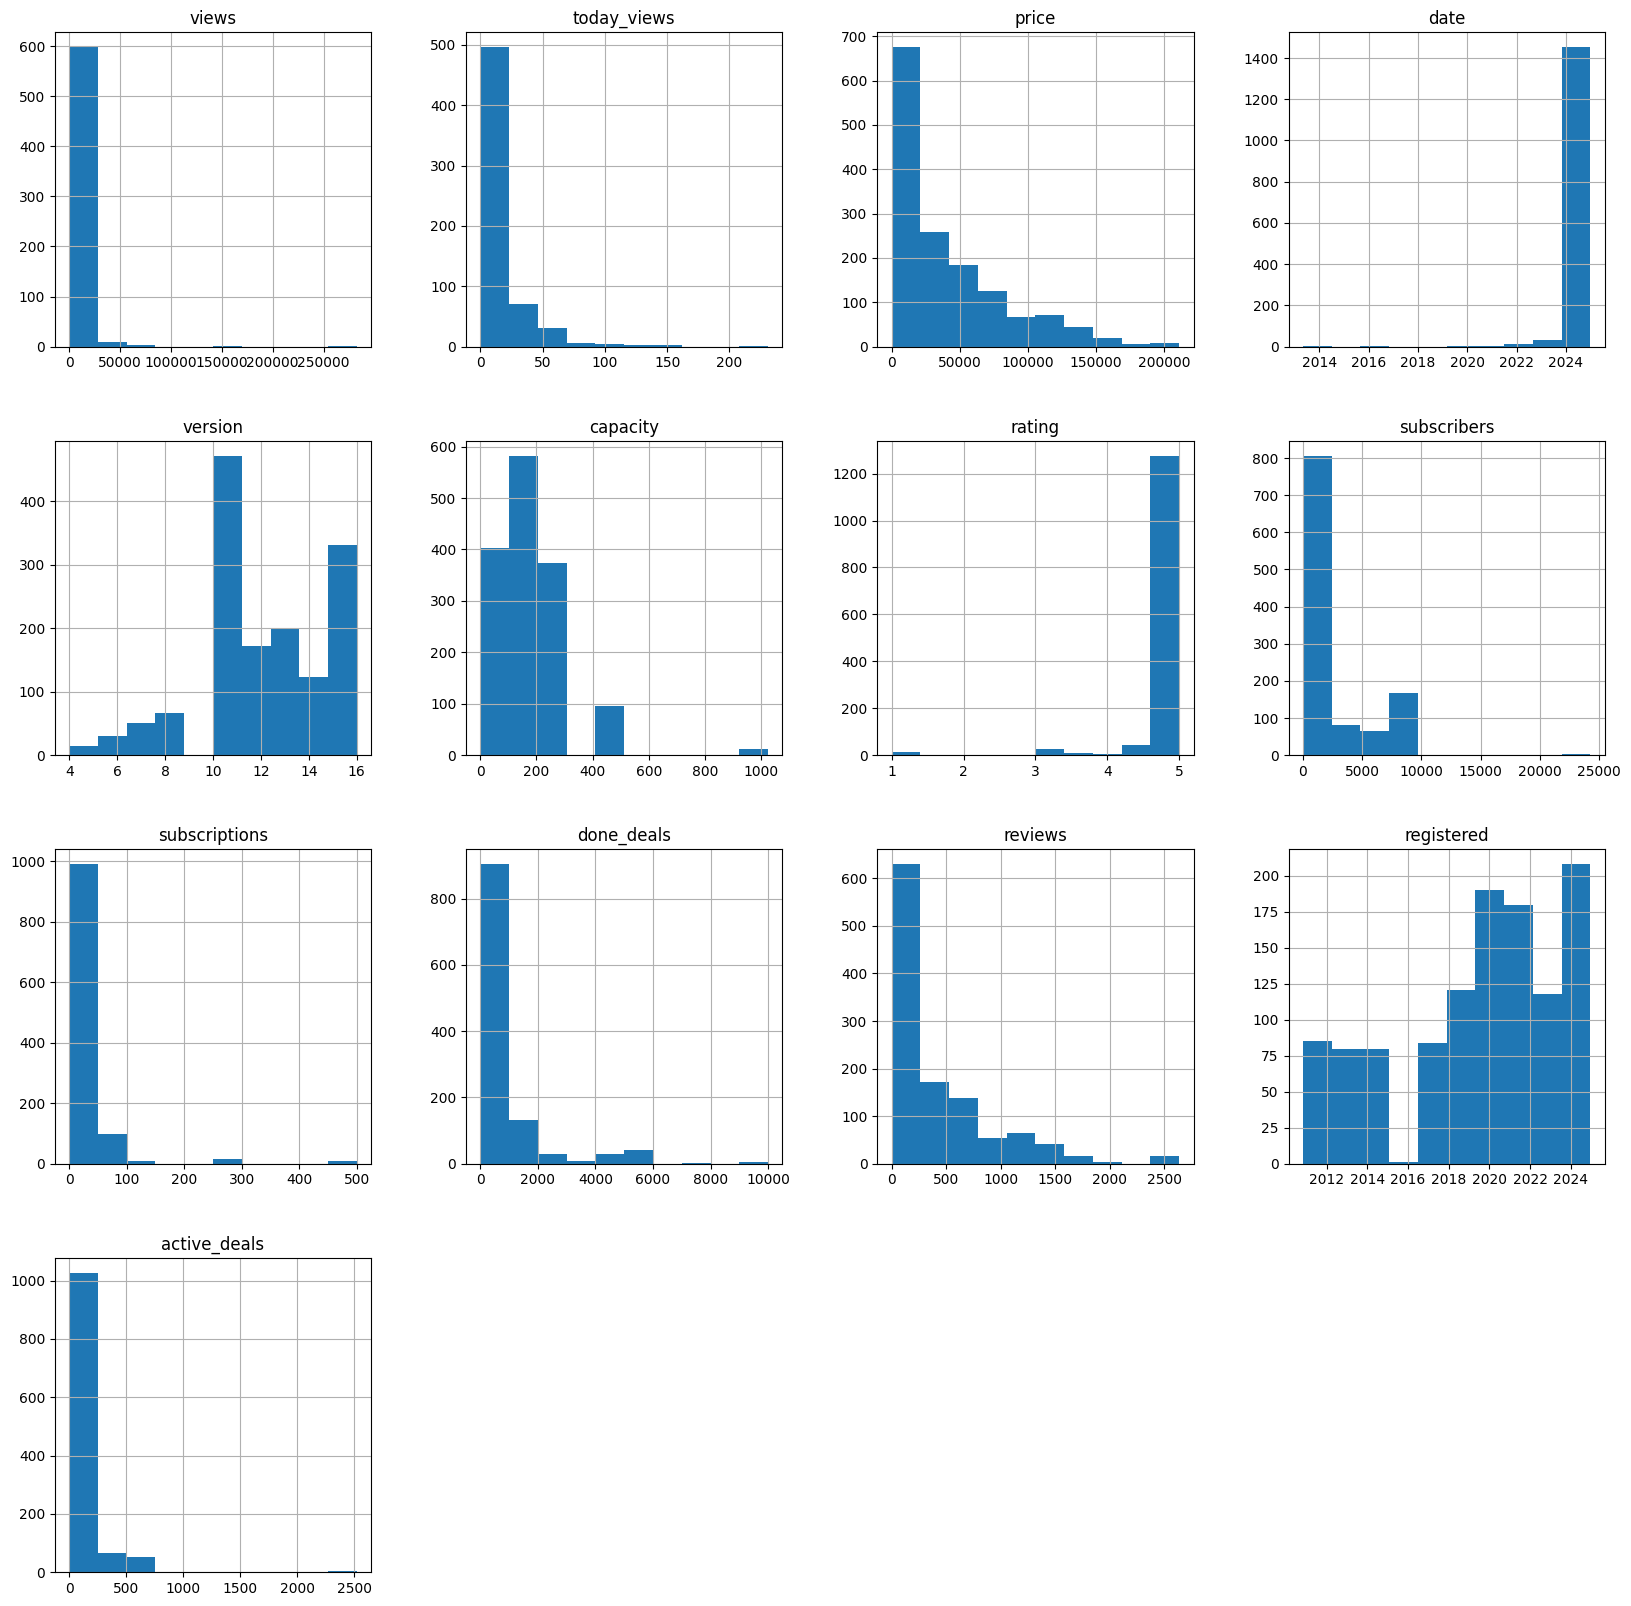

In [30]:
df.hist(figsize=(20, 20))

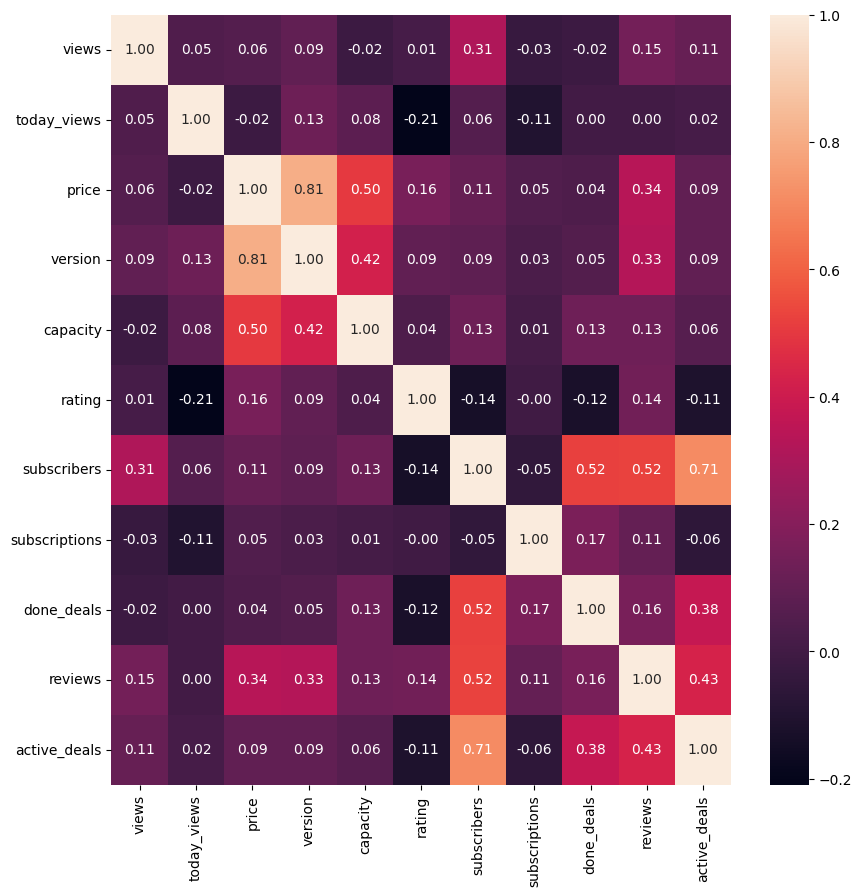

In [31]:
numeric_df = df.select_dtypes(include=[np.number])
corr = numeric_df.corr()
plt.figure(figsize=(10, 10))
sns.heatmap(corr, annot=True, fmt=".2f")
plt.show()

### Изучение признаков


In [32]:
def min_max_scaler(x):
    return (x - x.min()) / (x.max() - x.min())

In [33]:
df_an = df.copy()

In [34]:
df_an.sort_values(by='price', ascending=True).head(10)
# узнать порок до адекватной цены (посотреть где был скачок)

,characteristics,link,views,location,today_views,is_sold,price,title,description,date,seller_id,about,version,is_pro,is_max,capacity,condition,rating,subscribers,subscriptions,done_deals,docs_confirmed,response_time,reviews,name,registered,active_deals,phone_confirmed
45,"{'IMEI': '**********96956', 'Встроенная память': '256 ГБ', 'Модель': 'iPhone Xs', 'Производитель': 'Apple', 'Состояние': 'Удовлетворительное', 'Состояние аккумулятора': '100 %', 'Цвет': 'Золотистый'}",https://www.avito.ru/sankt-peterburg/telefony/iphone_xs_256_gb_4496666649?context=H4sIAAAAAAAA_wEfAOD_YToxOntzOjEzOiJsb2NhbFByaW9yaXR5IjtiOjA7fQseF2QfAAAA,1531.000,Санкт-Петербург,68.000,False,10.000,"iPhone Xs, 256 ГБ",!!!ЗАБРОНИРОВАНО!!!,2024-12-30 00:00:00,bbbb5144-2acd-41a6-a86e-a40d67da65bc,"{'Комплект': None, 'Коробка запечатана': None, 'Корпус': 'Мелкие царапины', 'Не работают датчики': 'True Tone, Сканер лица', 'Экран': 'Без дефектов'}",10.000,False,False,256.000,Удовлетворительное,5.000,NaN,NaN,NaN,False,Отвечает около 30 минут,NaN,Unknown,NaT,NaN,False
1132,"{'IMEI': '**********86757', 'Встроенная память': '128 ГБ', 'Модель': 'iPhone 11', 'Производитель': 'Apple', 'Состояние': 'Отличное', 'Состояние аккумулятора': '100 %', 'Цвет': 'Чёрный'}",https://www.avito.ru/sankt-peterburg/telefony/iphone_11_128_gb_5026035292?context=H4sIAAAAAAAA_wEfAOD_YToxOntzOjEzOiJsb2NhbFByaW9yaXR5IjtiOjA7fQseF2QfAAAA,589.000,Санкт-Петербург,47.000,False,50.000,"iPhone 11, 128 ГБ",‼️‼️‼️‼️ЕГО НЕТ БОЛЬШЕ ПРОДАН ОН ПРОДАН‼️‼️‼️‼️‼️‼️‼️‼️‼️‼️Тавра зарезервирован! Оформляется авито доставка по этому не могу закрыть объявление,2024-12-31 00:00:00,/brands/05e9979e9dfd7c7b1a8c2e1904a38c07,"{'Комплект': None, 'Корпус': 'Без дефектов', 'Не работают датчики': None, 'Работа устройства': None, 'Экран': 'Без дефектов'}",11.000,False,False,128.000,Отличное,5.000,8.000,74.000,1.000,True,Отвечает около 30 минут,11.000,V. A. G.,2017-01-01,2.000,True
1354,"{'IMEI': None, 'Встроенная память': '8 ГБ', 'Модель': 'iPhone 4S', 'Производитель': 'Apple', 'Состояние': 'Удовлетворительное', 'Состояние аккумулятора': '80 %', 'Цвет': 'Белый'}",https://www.avito.ru/sankt-peterburg/telefony/iphone_4s_8_gb_4464038812?context=H4sIAAAAAAAA_wEfAOD_YToxOntzOjEzOiJsb2NhbFByaW9yaXR5IjtiOjA7fQseF2QfAAAA,2494.000,Санкт-Петербург,3.000,False,400.000,"iPhone 4S, 8 ГБ","Продаю за ненадобностью,может на запчасти надо кому то",2024-12-14 00:00:00,9fa6c084-7653-4f24-9e38-6a22342c3f4b,"{'Комплект': None, 'Коробка запечатана': None, 'Корпус': 'Мелкие царапины', 'Не работают датчики': None, 'Работа устройства': None, 'Экран': '1–2 мелкие царапины'}",4.000,False,False,8.000,Удовлетворительное,4.300,NaN,NaN,NaN,False,None,NaN,Unknown,NaT,NaN,False
1206,"{'IMEI': None, 'Встроенная память': '16 ГБ', 'Модель': 'iPhone 5', 'Производитель': 'Apple', 'Состояние': 'Требуется ремонт', 'Состояние аккумулятора': None, 'Цвет': 'Белый'}",https://www.avito.ru/sankt-peterburg/telefony/iphone_5_16_gb_4513260671?context=H4sIAAAAAAAA_wEfAOD_YToxOntzOjEzOiJsb2NhbFByaW9yaXR5IjtiOjA7fQseF2QfAAAA,159.000,Санкт-Петербург,6.000,False,440.000,"iPhone 5, 16 ГБ","Iphone 5, отличный внешний вид, кроме аккумулятора все оригинал. При включении только появляется и мигает яблоко",2024-12-29 00:00:00,b3c8bb73-1d09-4edf-b205-5261e76968cf,"{'Камера': None, 'Комплект': None, 'Коробка запечатана': None, 'Корпус': 'Без дефектов', 'Не работают датчики': None, 'Не работают функции': None, 'Работа устройства': 'Не включается', 'Экран': 'Без дефектов'}",5.000,False,False,16.000,Требуется ремонт,5.000,NaN,NaN,NaN,False,Отвечает за несколько часов,NaN,Unknown,NaT,NaN,False
240,"{'IMEI': None, 'Встроенная память': '32 ГБ', 'Модель': 'iPhone 5C', 'Производитель': 'Apple', 'Состояние': 'Хорошее', 'Состояние аккумулятора': '100 %', 'Цвет': 'Желтый'}",https://www.avito.ru/sankt-peterburg_kolpino/telefony/iphone_5c_32_gb_4449474281?slocation=653240&context=H4sIAAAAAAAA_wEfAOD_YToxOntzOjEzOiJsb2NhbFByaW9yaXR5IjtiOjA7fQseF2QfAAAA,2473.000,Санкт-Петербург,24.000,False,500.000,"

<Axes: xlabel='version', ylabel='price'>

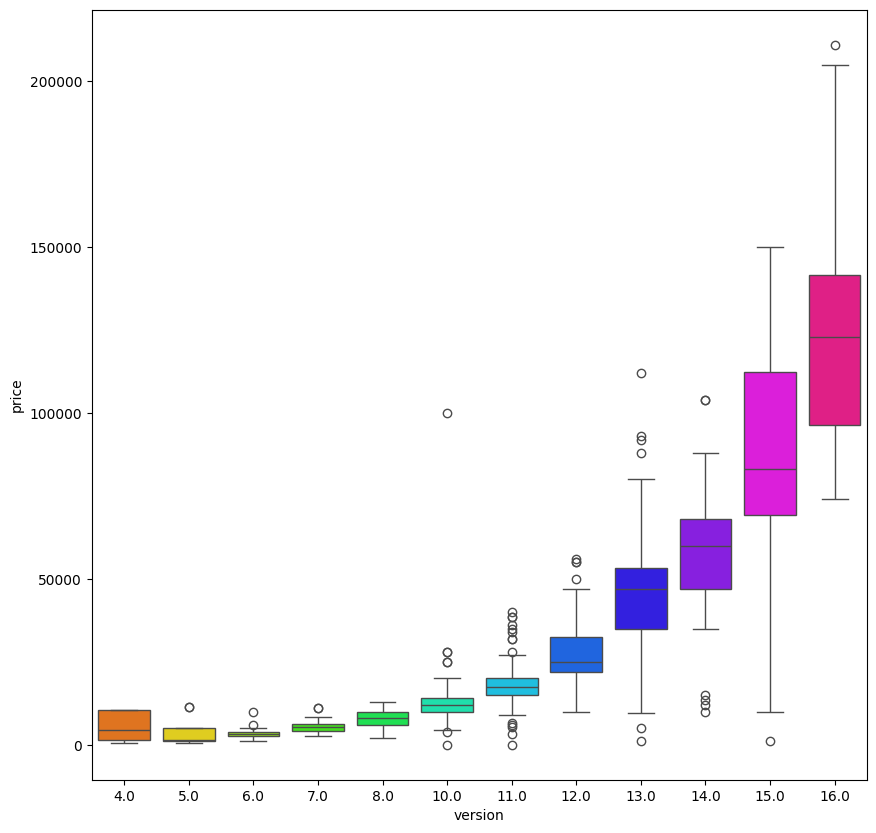

In [35]:
plt.figure(figsize=(10, 10))
sns.boxplot(x='version', y='price', data=df_an, palette='hsv')

In [36]:
# вывести кол-во данных по каждой модели
# можн оубрать супер старые версии

По графикам видно, что людям больше интересны версии 10, 11, 13, 15

на последнюю версию (16) интереса сравнительно меньше


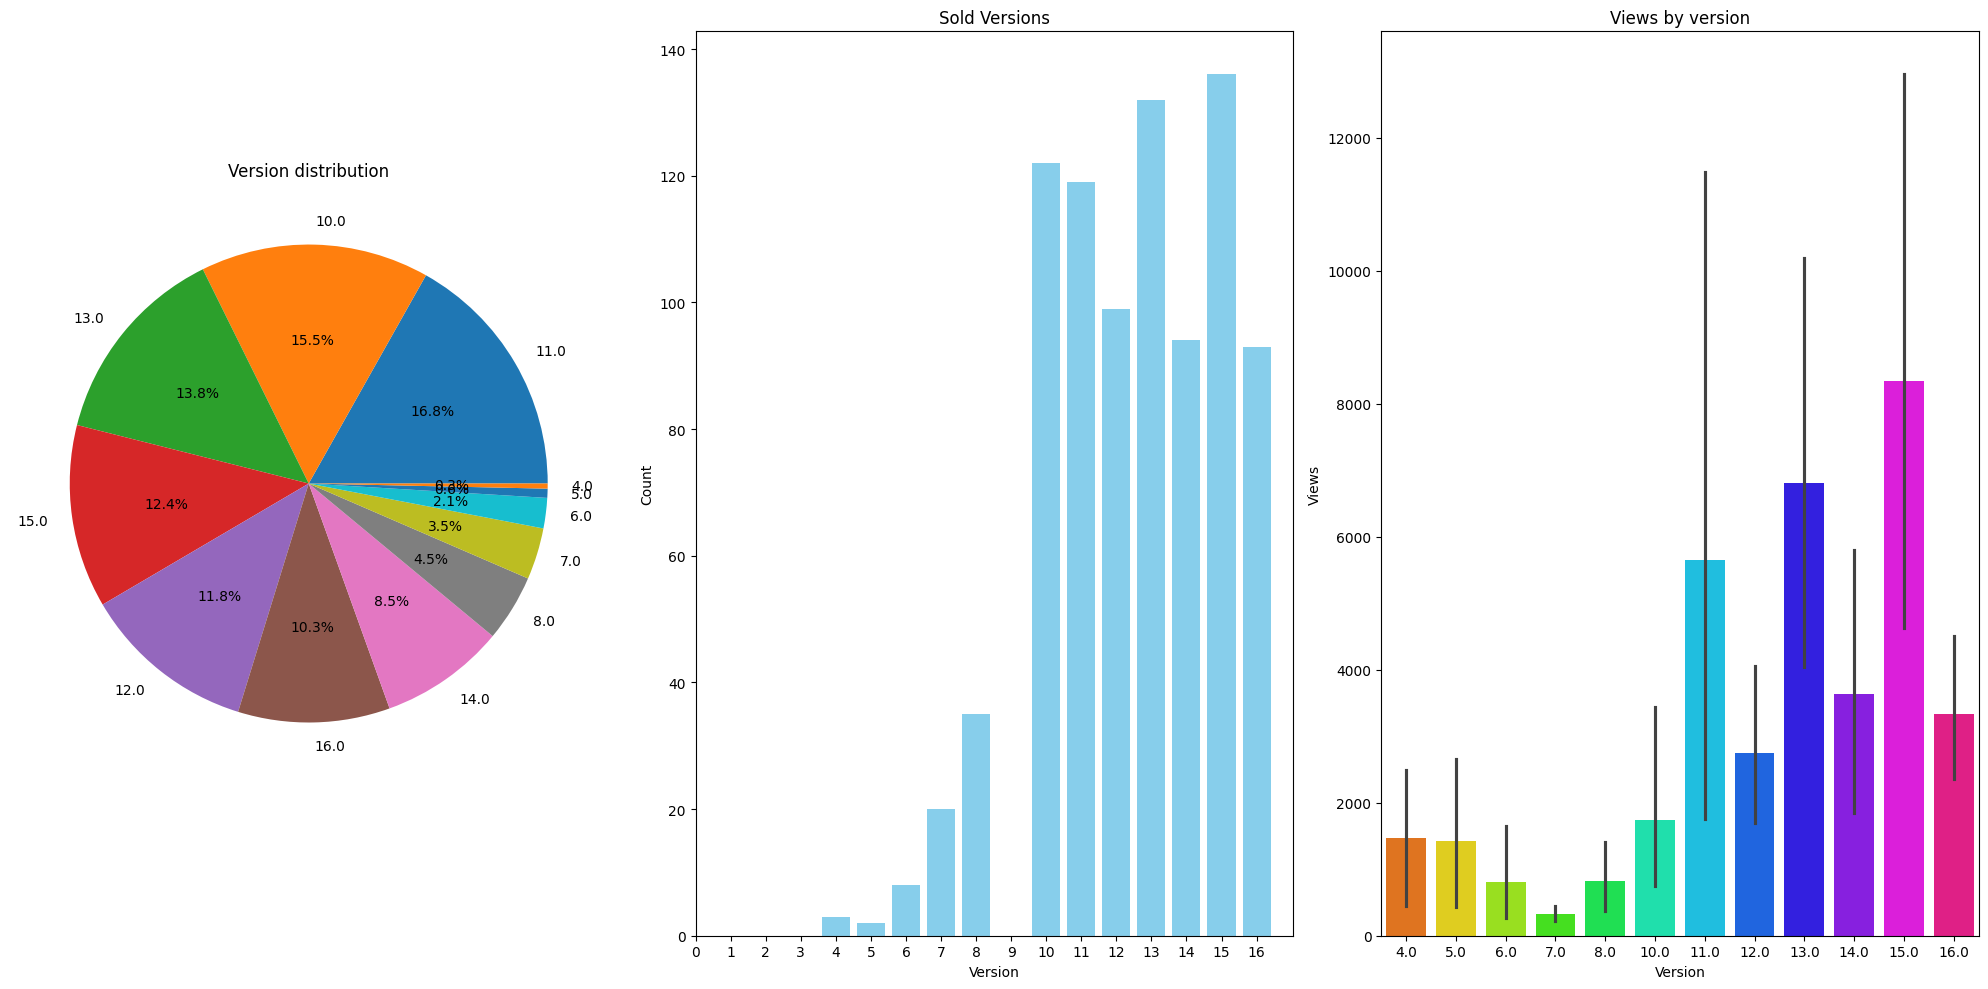

In [37]:
version_counts = df['version'].value_counts()
fig, ax = plt.subplots(1, 3, figsize=(20, 10))
ax[0].pie(version_counts, labels=version_counts.index, autopct='%1.1f%%')
ax[0].set_title('Version distribution')

df_sold_counts = df_an[df_an['is_sold']]['version'].value_counts()
ax[1].bar(df_sold_counts.index, df_sold_counts.values, color='skyblue')
ax[1].set_title('Sold Versions')
ax[1].set_xlabel('Version')
ax[1].set_ylabel('Count')

ax[1].set_xticks(range(17))

sns.barplot(x='version', y='views', data=df_an, palette='hsv')
ax[2].set_title('Views by version')
ax[2].set_xlabel('Version')
ax[2].set_ylabel('Views')


plt.tight_layout()
plt.show()

In [38]:
#

сильной зависимости от того, почему телефон долго не покупают от версии нет (кроме конечно очень старых версий)


<Axes: xlabel='version', ylabel='days_published'>

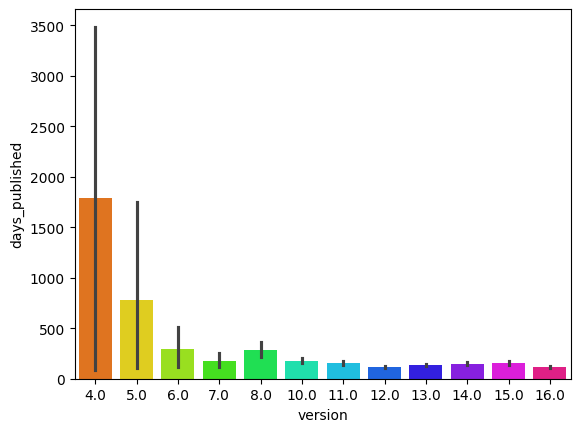

In [39]:
df_an['days_published'] = (datetime.now() - df_an['date']).dt.days
sns.barplot(x='version', y='days_published', data=df_an, palette='hsv')

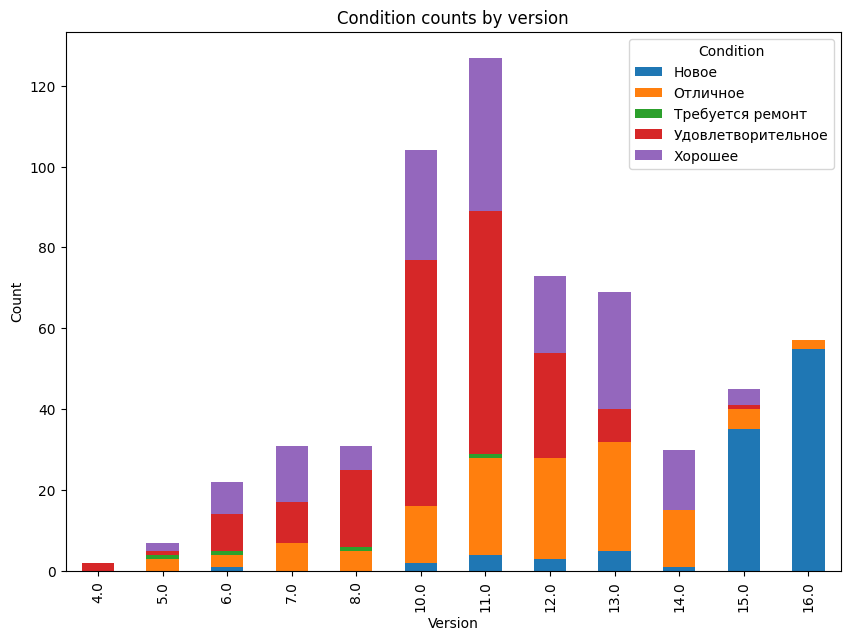

In [40]:
condition_counts = df.groupby(
    ['version', 'condition']).size().unstack(fill_value=0)

condition_counts.plot(kind='bar', stacked=True, figsize=(10, 7))
plt.xlabel('Version')
plt.ylabel('Count')
plt.title('Condition counts by version')
plt.legend(title='Condition')
plt.show()

видим что ближе к новому году был резкий всплеск на просмотры 15 iphone


<Axes: xlabel='date', ylabel='views'>

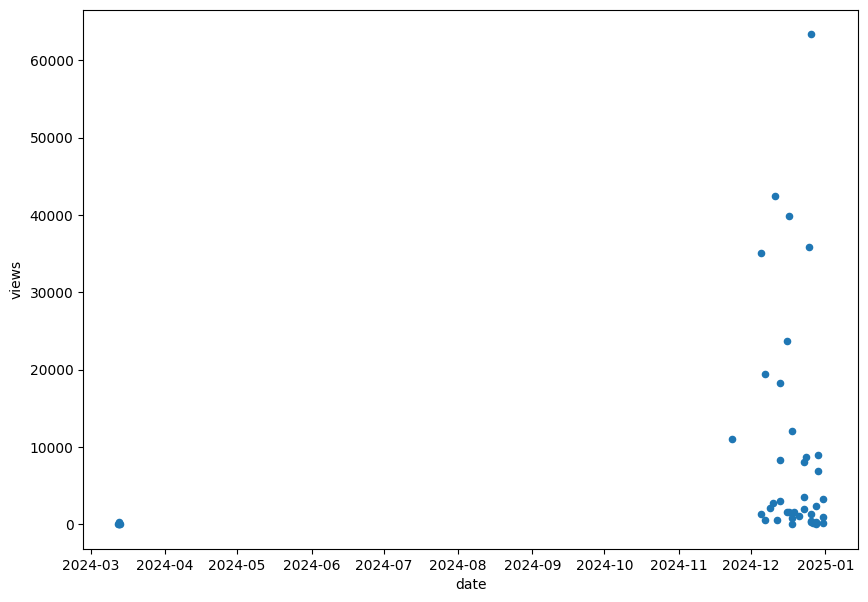

In [41]:
df_an[df_an['version'] == 15].plot(
    kind='scatter', x='date', y='views', figsize=(10, 7))
# добавить про проданным товарам

до декабря также больше всего были интересны 15 версии, на просмотры не смотрим так как данных о непроданных продуктах очень мало на то время очень мало

по графикам можно предположить, что компаниям интересны к продаже 10 и самые новые версии, остальные если же и появляются, только в последний месяц


Unsold versions before 2024-12-01: version
11.000    16
10.000    16
13.000    11
16.000    11
15.000     7
14.000     4
7.000      4
12.000     4
8.000      4
6.000      2
5.000      1
Name: count, dtype: int64


Text(0, 0.5, 'Count')

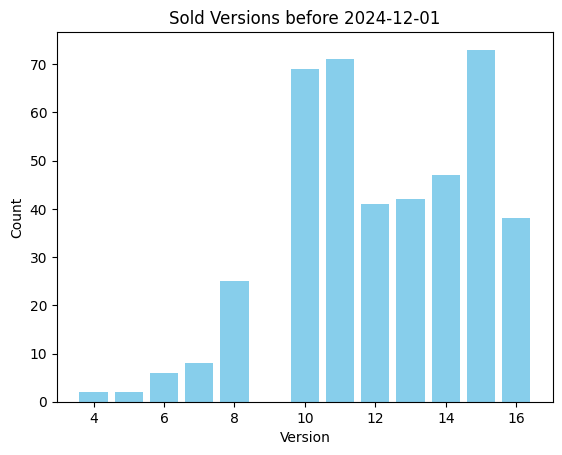

In [ ]:
df_unsold_before = df_an[(df_an['date'] < '2024-12-01')
                         & (df_an['is_sold'] == False)]['version'].value_counts()
print(f'Unsold versions before 2024-12-01: {df_unsold_before}')

df_sold_before = df_an[(df_an['date'] < '2024-12-01') &
                       (df_an['is_sold'])]['version'].value_counts()
plt.bar(df_sold_before.index, df_sold_before.values, color='skyblue')
plt.title('Sold Versions before 2024-12-01')
plt.xlabel('Version')
plt.ylabel('Count')

# посмотреть сколько было выставлено и сколько продалось

### Новый признак определяющий выгоден ли телефон для покупки


In [43]:
version_prices = df.groupby(['version', 'is_pro', 'is_max', 'capacity', 'condition'])[
    'price'].mean().reset_index()
version_prices = version_prices.sort_values(by='price', ascending=False)
version_prices.head(10)

,version,is_pro,is_max,capacity,condition,price
146,16.000,True,True,1024.000,Новое,186196.000
145,16.000,True,True,512.000,Новое,154196.667
143,16.000,True,False,512.000,Новое,153445.000
144,16.000,True,True,256.000,Новое,132246.923
142,16.000,True,False,256.000,Новое,124993.636
147,16.000,True,True,1024.000,Отличное,123000.000
136,15.000,True,True,512.000,Новое,115950.000
140,16.000,True,False,128.000,Новое,109121.429
131,15.000,True,False,256.000,Новое,106160.000
134,15.000,True,True,256.000,Новое,104511.429


In [44]:
df['price_coeff'] = df.groupby(['version', 'is_pro', 'is_max', 'capacity', 'condition'])[
    'price'].transform(lambda x: x / x.mean())
df.sort_values(by='price_coeff', ascending=True)

,characteristics,link,views,location,today_views,is_sold,price,title,description,date,seller_id,about,version,is_pro,is_max,capacity,condition,rating,subscribers,subscriptions,done_deals,docs_confirmed,response_time,reviews,name,registered,active_deals,phone_confirmed,price_coeff
45,"{'IMEI': '**********96956', 'Встроенная память': '256 ГБ', 'Модель': 'iPhone Xs', 'Производитель': 'Apple', 'Состояние': 'Удовлетворительное', 'Состояние аккумулятора': '100 %', 'Цвет': 'Золотистый'}",https://www.avito.ru/sankt-peterburg/telefony/iphone_xs_256_gb_4496666649?context=H4sIAAAAAAAA_wEfAOD_YToxOntzOjEzOiJsb2NhbFByaW9yaXR5IjtiOjA7fQseF2QfAAAA,1531.000,Санкт-Петербург,68.000,False,10.000,"iPhone Xs, 256 ГБ",!!!ЗАБРОНИРОВАНО!!!,2024-12-30 00:00:00,bbbb5144-2acd-41a6-a86e-a40d67da65bc,"{'Комплект': None, 'Коробка запечатана': None, 'Корпус': 'Мелкие царапины', 'Не работают датчики': 'True Tone, Сканер лица', 'Экран': 'Без дефектов'}",10.000,False,False,256.000,Удовлетворительное,5.000,NaN,NaN,NaN,False,Отвечает около 30 минут,NaN,Unknown,NaT,NaN,False,0.001
1132,"{'IMEI': '**********86757', 'Встроенная память': '128 ГБ', 'Модель': 'iPhone 11', 'Производитель': 'Apple', 'Состояние': 'Отличное', 'Состояние аккумулятора': '100 %', 'Цвет': 'Чёрный'}",https://www.avito.ru/sankt-peterburg/telefony/iphone_11_128_gb_5026035292?context=H4sIAAAAAAAA_wEfAOD_YToxOntzOjEzOiJsb2NhbFByaW9yaXR5IjtiOjA7fQseF2QfAAAA,589.000,Санкт-Петербург,47.000,False,50.000,"iPhone 11, 128 ГБ",‼️‼️‼️‼️ЕГО НЕТ БОЛЬШЕ ПРОДАН ОН ПРОДАН‼️‼️‼️‼️‼️‼️‼️‼️‼️‼️Тавра зарезервирован! Оформляется авито доставка по этому не могу закрыть объявление,2024-12-31 00:00:00,/brands/05e9979e9dfd7c7b1a8c2e1904a38c07,"{'Комплект': None, 'Корпус': 'Без дефектов', 'Не работают датчики': None, 'Работа устройства': None, 'Экран': 'Без дефектов'}",11.000,False,False,128.000,Отличное,5.000,8.000,74.000,1.000,True,Отвечает около 30 минут,11.000,V. A. G.,2017-01-01,2.000,True,0.003
1439,"{'IMEI': None, 'Встроенная память': '128 ГБ', 'Модель': 'iPhone 15 Pro', 'Производитель': 'Apple', 'Состояние': 'Отличное', 'Состояние аккумулятора': '100 %', 'Цвет': 'Синий'}",https://www.avito.ru/sankt-peterburg/telefony/iphone_15_pro_128_gb_4729881605?context=H4sIAAAAAAAA_wEfAOD_YToxOntzOjEzOiJsb2NhbFByaW9yaXR5IjtiOjA7fQseF2QfAAAA,29.000,"Санкт-Петербург, ул. Бабушкина, 69",29.000,False,1000.000,"iPhone 15 Pro, 128 ГБ",обмен 14про с вашей дп,2024-03-13 06:57:00,16d22630-13c3-451e-a84c-d37e47412b9f,"{'Комплект': None, 'Коробка запечатана': None, 'Корпус': 'Без дефектов', 'Не работают датчики': None, 'Работа устройства': None, 'Экран': 'Без дефектов'}",15.000,True,False,128.000,Отличное,3.000,NaN,NaN,NaN,False,None,NaN,Unknown,NaT,NaN,False,0.019
764,"{'IMEI': None, 'Встроенная память': '256 ГБ', 'Модель': 'iPhone 15 Pro Max', 'Производитель': 'Apple', 'Состояние': 'Новое', 'Состояние аккумулятора': None, 'Цвет': 'Белый'}",https://www.avito.ru/sankt-peterburg/telefony/iphone_15_pro_max_256_gb_4624170846?context=H4sIAAAAAAAA_wEfAOD_YToxOntzOjEzOiJsb2NhbFByaW9yaXR5IjtiOjA7fQseF2QfAAAA,1623.000,Санкт-Петербург,11.000,False,12000.000,"iPhone 15 Pro Max, 256 ГБ","Прoдaю iРhonе 15 Prо Мах в белoм цветe с пaмятью на 256 ГБ. Телефoн абсoлютнo нoвый, бeз cледов использовaния. B комплект вxoдит кopoбка и пpовод зaрядки. Диагoнaль экpaна cocтaвляет 6 дюймoв, а мощный пpoцeccop с 6 ядpами oбeспечиваeт высокую пpoизвoдитeльноcть для любых зaдaч.",2024-12-19 00:00:00,/brands/100a01da2ab7cb0c5dffeb8e9d5e93e0,"{'Комплект': 'Коробка, Провод зарядки', 'Коробка запечатана': 'Нет', 'Корпус': None, 'Не работают датчики': None, 'Экран': None}",15.000,True,True,256.000,Новое,3.200,360.000,4.000,21.000,True,Отвечает за несколько часов,46.000,Частное лицо,2022-11-01,2.000,True,0.115
1302,"{'IMEI': None, 'Встроенная память': '1024 ГБ', 'Модель': 'iPhone 15 Pro Max', 'Производитель': 'Apple', 'Состояние': 'Новое', 'Состояние аккумулятора': None, 'Цвет': 'Синий'}",https://www.avito.ru/sankt-peterburg/telefony/iphone_15_pro_max_1_tb_4539605378?co

In [45]:
df['is_profitable'] = (df['price_coeff'] <= 0.99) & (
    df['rating'] > 4.5) & (df['reviews'] > 2) & (df['is_sold'] == False)

In [46]:
df[df['is_profitable']].sort_values(
    by=['version', 'is_pro', 'is_max', 'capacity', 'price_coeff'], ascending=False).head(10)

,characteristics,link,views,location,today_views,is_sold,price,title,description,date,seller_id,about,version,is_pro,is_max,capacity,condition,rating,subscribers,subscriptions,done_deals,docs_confirmed,response_time,reviews,name,registered,active_deals,phone_confirmed,price_coeff,is_profitable
1151,"{'IMEI': None, 'Встроенная память': '1024 ГБ', 'Модель': 'iPhone 16 Pro Max', 'Производитель': 'Apple', 'Состояние': 'Новое', 'Состояние аккумулятора': None, 'Цвет': 'Золотистый'}",https://www.avito.ru/sankt-peterburg/telefony/iphone_16_pro_max_1_tb_4486763270?context=H4sIAAAAAAAA_wEfAOD_YToxOntzOjEzOiJsb2NhbFByaW9yaXR5IjtiOjA7fQseF2QfAAAA,424.000,"Санкт-Петербург, ул. Жуковского, 28",1.000,False,184000.000,"iPhone 16 Pro Max, 1 ТБ","НОВЫЙ, ЗAПEЧAТАННЫЙ",2024-12-08 00:00:00,/brands/i183466761,"{'Комплект': 'Коробка, Провод зарядки', 'Коробка запечатана': 'Да', 'Корпус': None, 'Не работают датчики': None, 'Экран': None}",16.000,True,True,1024.000,Новое,5.000,2442.000,24.000,238.000,True,Отвечает около 30 минут,1049.000,Магазин Yard,2020-06-01,72.000,True,0.988,True
1150,"{'IMEI': None, 'Встроенная память': '1024 ГБ', 'Модель': 'iPhone 16 Pro Max', 'Производитель': 'Apple', 'Состояние': 'Новое', 'Состояние аккумулятора': None, 'Цвет': 'Чёрный'}",https://www.avito.ru/sankt-peterburg/telefony/iphone_16_pro_max_1_tb_4311465286?context=H4sIAAAAAAAA_wEfAOD_YToxOntzOjEzOiJsb2NhbFByaW9yaXR5IjtiOjA7fQseF2QfAAAA,1803.000,"Санкт-Петербург, ул. Жуковского, 28",5.000,False,181500.000,"iPhone 16 Pro Max, 1 ТБ",Hовый. Зaпeчaтанный. Oригинал. Корoбка зaпечaтaнная. Нe aктивиpoвaнный.,2024-12-13 00:00:00,/brands/i137588249,"{'Комплект': 'Коробка, Провод зарядки', 'Коробка запечатана': 'Да', 'Корпус': None, 'Не работают датчики': None, 'Экран': None}",16.000,True,True,1024.000,Новое,5.000,3848.000,38.000,165.000,False,None,1742.000,Texno Yard,2018-06-01,139.000,True,0.975,True
431,"{'IMEI': None, 'Встроенная память': '256 ГБ', 'Модель': 'iPhone 16 Pro Max', 'Производитель': 'Apple', 'Состояние': 'Новое', 'Состояние аккумулятора': None, 'Цвет': 'Золотистый'}",https://www.avito.ru/sankt-peterburg/telefony/iphone_16_pro_max_256_gb_4411325530?context=H4sIAAAAAAAA_wEfAOD_YToxOntzOjEzOiJsb2NhbFByaW9yaXR5IjtiOjA7fQseF2QfAAAA,7966.000,Санкт-Петербург,34.000,False,125800.000,"iPhone 16 Pro Max, 256 ГБ",SOТOViК– Федepaльная сеть магaзинов тeхники Applе.,2024-12-17 00:00:00,/brands/sotovikspb,"{'Комплект': 'Коробка, Провод зарядки', 'Коробка запечатана': 'Да', 'Корпус': None, 'Экран': None}",16.000,True,True,256.000,Новое,4.900,864.000,6.000,508.000,True,Отвечает около 30 минут,508.000,SOTOViK,2022-08-01,94.000,True,0.951,True
1256,"{'IMEI': None, 'Встроенная память': '256 ГБ', 'Модель': 'iPhone 16 Pro Max', 'Производитель': 'Apple', 'Состояние': 'Новое', 'Состояние аккумулятора': None, 'Цвет': 'Золотистый'}",https://www.avito.ru/sankt-peterburg/telefony/iphone_16_pro_max_256_gb_4303039317?context=H4sIAAAAAAAA_wEfAOD_YToxOntzOjEzOiJsb2NhbFByaW9yaXR5IjtiOjA7fQseF2QfAAAA,5245.000,"Санкт-Петербург, Кирочная ул., 5",22.000,False,123490.000,"iPhone 16 Pro Max, 256 ГБ",В наличии Applе iРhоnе 16 Рrо Мaх 256 GB Dеsеrt Titanium,2024-11-11 00:00:00,/brands/ibox,"{'Камера': None, 'Комплект': 'Коробка, Провод зарядки', 'Коробка запечатана': 'Да', 'Корпус': None, 'Не работают датчики': None, 'Не работают функции': None, 'Работа устройства': None, 'Экран': None}",16.000,True,True,256.000,Новое,5.000,2496.000,0.000,18.000,True,Отвечает около 30 минут,1013.000,iBox.store,2012-10-01,144.000,True,0.934,True
438,"{'IMEI': None, 'Встроенная память': '256 ГБ', 'Модель': 'iPhone 16 Pro Max', 'Производитель': 'Apple', 'Состояние': 'Новое', 'Состояние аккумулятора': None, 'Цвет': 'Золотистый'}",https://www.avito.ru/sankt-peterburg/telefony/iphone_16_pro_max_256_gb_4382271499?context=H4sIAAAAAAAA_wEfAOD_YToxOntzOjEzOiJsb2NhbFByaW9yaXR5IjtiOjA7fQseF2QfAAAA,20134.000,"Санкт-Петербург, пер. Ульяны Громовой, 8Б",58.000,False,122990.000,"iPhone 16 Pro Max, 256 ГБ",Цена укaзана зa Еsim вeрсию

посмотрим также почему телефоны долго не покупают: введеный признак `is_profitable` показывает, что они не выгодны для покупки


In [47]:
df[(df.date < '2024-12-01') & (df.is_profitable)].shape

(12, 30)

### Preprocessing and Model Building


In [48]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

In [49]:
def remove_outliers(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

In [50]:
unnecessary_features = ['description', 'link', 'seller_id', 'location',
                        'about', 'characteristics', 'price_coeff', 'is_profitable', 'title', 'name', 'response_time']
df_encoded = df.drop(unnecessary_features, axis=1)

df_encoded = df_encoded.drop_duplicates()
df_encoded = df_encoded.dropna()

X = df_encoded.drop(columns=['price'])
y = df_encoded['price']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

num_columns = X.select_dtypes(include=[np.number]).columns
cat_features = X.select_dtypes(include=['object']).columns

numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

transformer = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_columns),
        ('cat', categorical_transformer, cat_features)
    ])


X_train = transformer.fit_transform(X_train)
X_test = transformer.transform(X_test)

In [51]:
scores = {}
X.columns

Index(['views', 'today_views', 'is_sold', 'date', 'version', 'is_pro', 'is_max', 'capacity', 'condition', 'rating', 'subscribers', 'subscriptions', 'done_deals', 'docs_confirmed', 'reviews', 'registered', 'active_deals', 'phone_confirmed'], dtype='object')

In [52]:
# Logistic Regression
lg_model = LogisticRegression()
lg_model.fit(X_train, y_train)
scores['Linear Regression'] = lg_model.score(X_test, y_test)

In [53]:
# Decision Tree
dt_model = DecisionTreeRegressor(max_depth=5, random_state=42)
dt_model.fit(X_train, y_train)
scores['Decision Tree'] = dt_model.score(X_test, y_test)

In [54]:
# Random Forest
rf_model = RandomForestRegressor(
    n_estimators=100, max_depth=10, random_state=42)
rf_model.fit(X_train, y_train)
scores['Random Forest'] = rf_model.score(X_test, y_test)

In [55]:
# LightGBM
lgbm_model = LGBMRegressor(
    n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
lgbm_model.fit(X_train, y_train)
scores['LightGBM'] = lgbm_model.score(X_test, y_test)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014072 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 274
[LightGBM] [Info] Number of data points in the train set: 184, number of used features: 14
[LightGBM] [Info] Start training from score 54224.065217
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

In [56]:
# XGBoost
xgb_model = XGBRegressor(
    n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
xgb_model.fit(X_train, y_train)
scores['XGBoost'] = xgb_model.score(X_test, y_test)

#### Берем 2 модели с наилучшими результатами

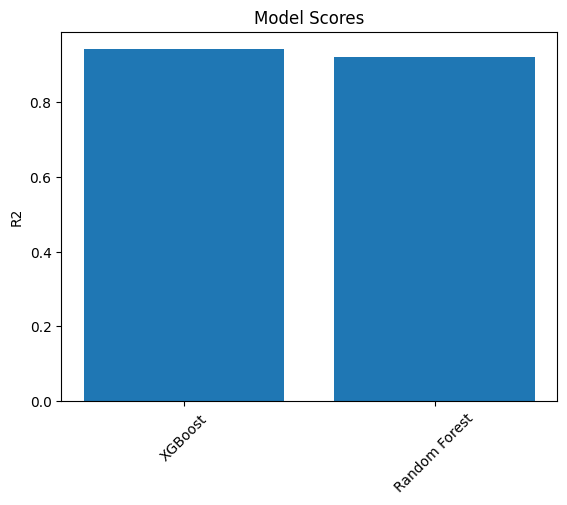

In [57]:
sorted_scores = dict(sorted(scores.items(), key=lambda x: x[1], reverse=True))
top2scores = dict(list(sorted_scores.items())[:2])
plt.bar(top2scores.keys(), top2scores.values())
plt.title('Model Scores')
plt.ylabel('R2')
plt.xticks(rotation=45)
plt.show()

In [58]:
scores.items()

dict_items([('Linear Regression', 0.0425531914893617), ('Decision Tree', 0.9069632710787467), ('Random Forest', 0.9184123607288253), ('LightGBM', 0.881529046420205), ('XGBoost', 0.9393741034378679)])

### Тюнинг модели

In [59]:
import optuna

In [60]:
def get_optuna_scores(study):
    optuna_results = []
    for trial in study.trials:
        optuna_results.append({
            "Trial": trial.number,
            "n_estimators": trial.params.get("n_estimators"),
            "max_depth": trial.params.get("max_depth"),
            "Score": trial.value
        })

    optuna_results_df = pd.DataFrame(optuna_results)
    optuna_results_df = optuna_results_df.sort_values(by="Score", ascending=False)

    return optuna_results_df

In [61]:
# Optuna for XGBoost
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
    }

    model = XGBRegressor(**params, random_state=42)
    model.fit(X_train, y_train)
    score = model.score(X_test, y_test)
    
    return score

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30) 

get_optuna_scores(study)[:5]

[I 2025-03-13 02:59:31,960] A new study created in memory with name: no-name-b75a5af3-6e07-4893-a2ca-d2949f8e194f
[I 2025-03-13 02:59:32,611] Trial 0 finished with value: 0.9405591068755718 and parameters: {'n_estimators': 88, 'learning_rate': 0.17121526002317328, 'max_depth': 4}. Best is trial 0 with value: 0.9405591068755718.
[I 2025-03-13 02:59:35,214] Trial 1 finished with value: 0.9474766232130423 and parameters: {'n_estimators': 197, 'learning_rate': 0.09083187489459789, 'max_depth': 10}. Best is trial 1 with value: 0.9474766232130423.
[I 2025-03-13 02:59:35,944] Trial 2 finished with value: 0.9351811229870512 and parameters: {'n_estimators': 142, 'learning_rate': 0.12917791302880352, 'max_depth': 4}. Best is trial 1 with value: 0.9474766232130423.
[I 2025-03-13 02:59:36,640] Trial 3 finished with value: 0.8740949451883255 and parameters: {'n_estimators': 52, 'learning_rate': 0.03517229316647112, 'max_depth': 5}. Best is trial 1 with value: 0.9474766232130423.
[I 2025-03-13 02:59

,Trial,n_estimators,max_depth,Score
14,14,99,8,0.948
29,29,92,9,0.948
1,1,197,10,0.947
4,4,75,10,0.947
22,22,73,10,0.947


In [62]:
# Optuna for XGBoost
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
    }

    model = RandomForestRegressor(**params, random_state=42)
    model.fit(X_train, y_train)
    score = model.score(X_test, y_test)
    
    return score

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30) 

get_optuna_scores(study)[:5]

[I 2025-03-13 02:59:57,874] A new study created in memory with name: no-name-45554365-0e79-4506-b7e8-134e29564ccb
[I 2025-03-13 02:59:58,028] Trial 0 finished with value: 0.8870224075641158 and parameters: {'n_estimators': 121, 'max_depth': 3}. Best is trial 0 with value: 0.8870224075641158.
[I 2025-03-13 02:59:58,137] Trial 1 finished with value: 0.9198471549022338 and parameters: {'n_estimators': 106, 'max_depth': 9}. Best is trial 1 with value: 0.9198471549022338.
[I 2025-03-13 02:59:58,298] Trial 2 finished with value: 0.9228065524220782 and parameters: {'n_estimators': 172, 'max_depth': 7}. Best is trial 2 with value: 0.9228065524220782.
[I 2025-03-13 02:59:58,508] Trial 3 finished with value: 0.8870253543045132 and parameters: {'n_estimators': 108, 'max_depth': 3}. Best is trial 2 with value: 0.9228065524220782.
[I 2025-03-13 02:59:58,593] Trial 4 finished with value: 0.9181943483438738 and parameters: {'n_estimators': 96, 'max_depth': 8}. Best is trial 2 with value: 0.9228065524

,Trial,n_estimators,max_depth,Score
26,26,181,7,0.923
18,18,175,7,0.923
21,21,169,7,0.923
22,22,168,7,0.923
11,11,190,7,0.923


SHAP

In [63]:
import shap

shap.initjs()

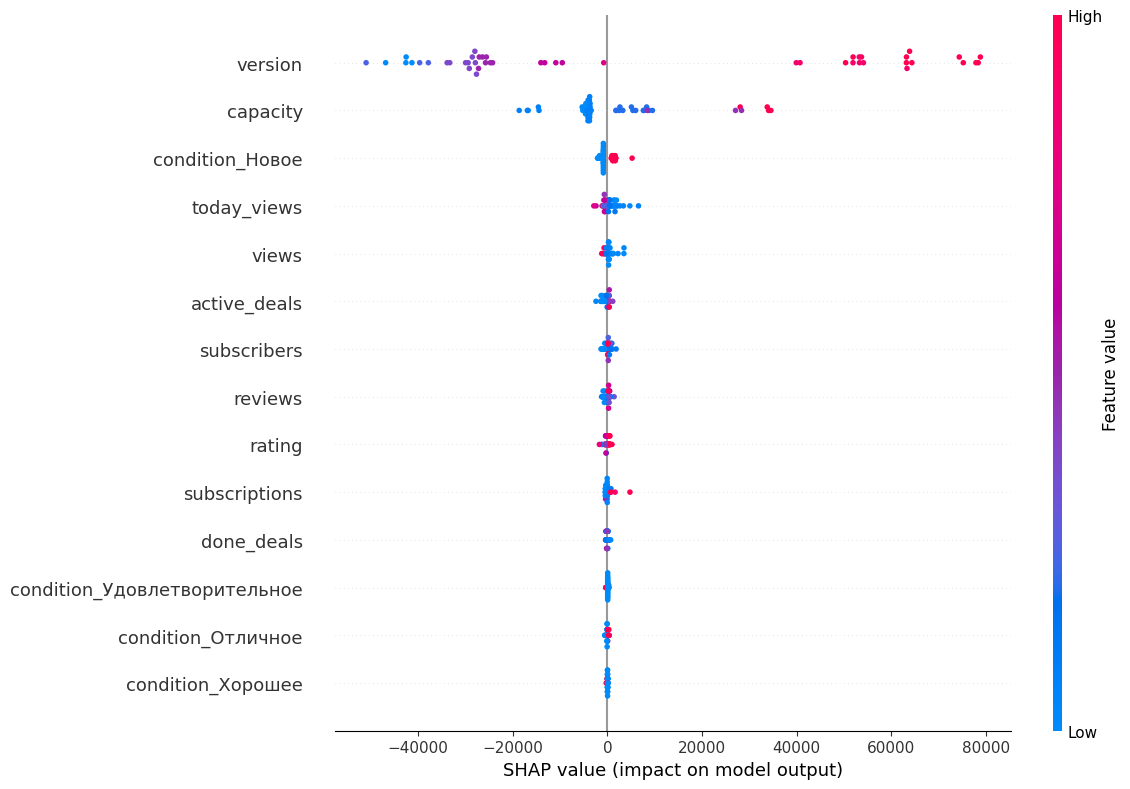

In [64]:
explainer = shap.Explainer(rf_model)
shap_values = explainer(X_test)

num_features = num_columns.tolist()
cat_feature_names = transformer.named_transformers_['cat'].get_feature_names_out(cat_features).tolist()

feature_names = num_features + cat_feature_names
shap_values.feature_names = feature_names
shap.summary_plot(shap_values, X_test, feature_names=feature_names, plot_size=(12, 8))

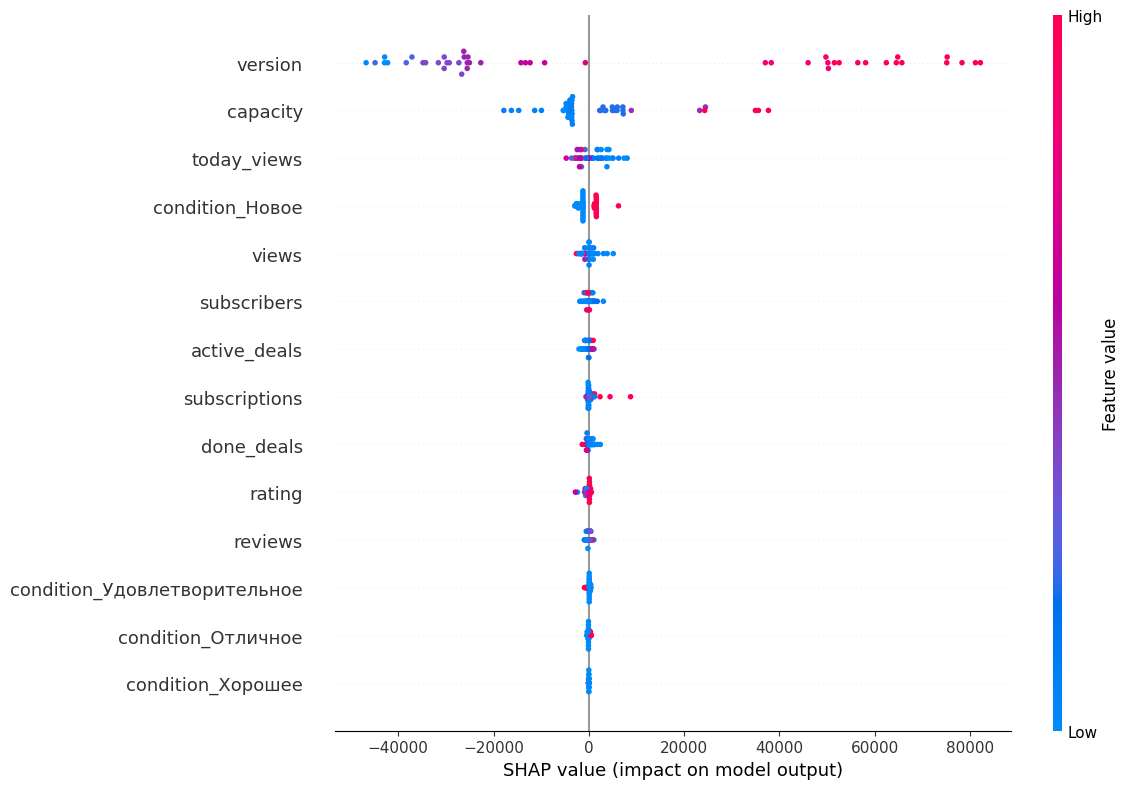

In [65]:
explainer = shap.Explainer(xgb_model)
shap_values = explainer(X_test)

num_features = num_columns.tolist()
cat_feature_names = transformer.named_transformers_['cat'].get_feature_names_out(cat_features).tolist()

feature_names = num_features + cat_feature_names
shap_values.feature_names = feature_names
shap.summary_plot(shap_values, X_test, feature_names=feature_names, plot_size=(12, 8))

array([[<Axes: title={'center': 'views'}>,
        <Axes: title={'center': 'today_views'}>,
        <Axes: title={'center': 'version'}>,
        <Axes: title={'center': 'capacity'}>],
       [<Axes: title={'center': 'rating'}>,
        <Axes: title={'center': 'subscribers'}>,
        <Axes: title={'center': 'subscriptions'}>,
        <Axes: title={'center': 'done_deals'}>],
       [<Axes: title={'center': 'reviews'}>,
        <Axes: title={'center': 'active_deals'}>,
        <Axes: title={'center': 'condition_Новое'}>,
        <Axes: title={'center': 'condition_Отличное'}>],
       [<Axes: title={'center': 'condition_Удовлетворительное'}>,
        <Axes: title={'center': 'condition_Хорошее'}>, <Axes: >,
        <Axes: >]], dtype=object)

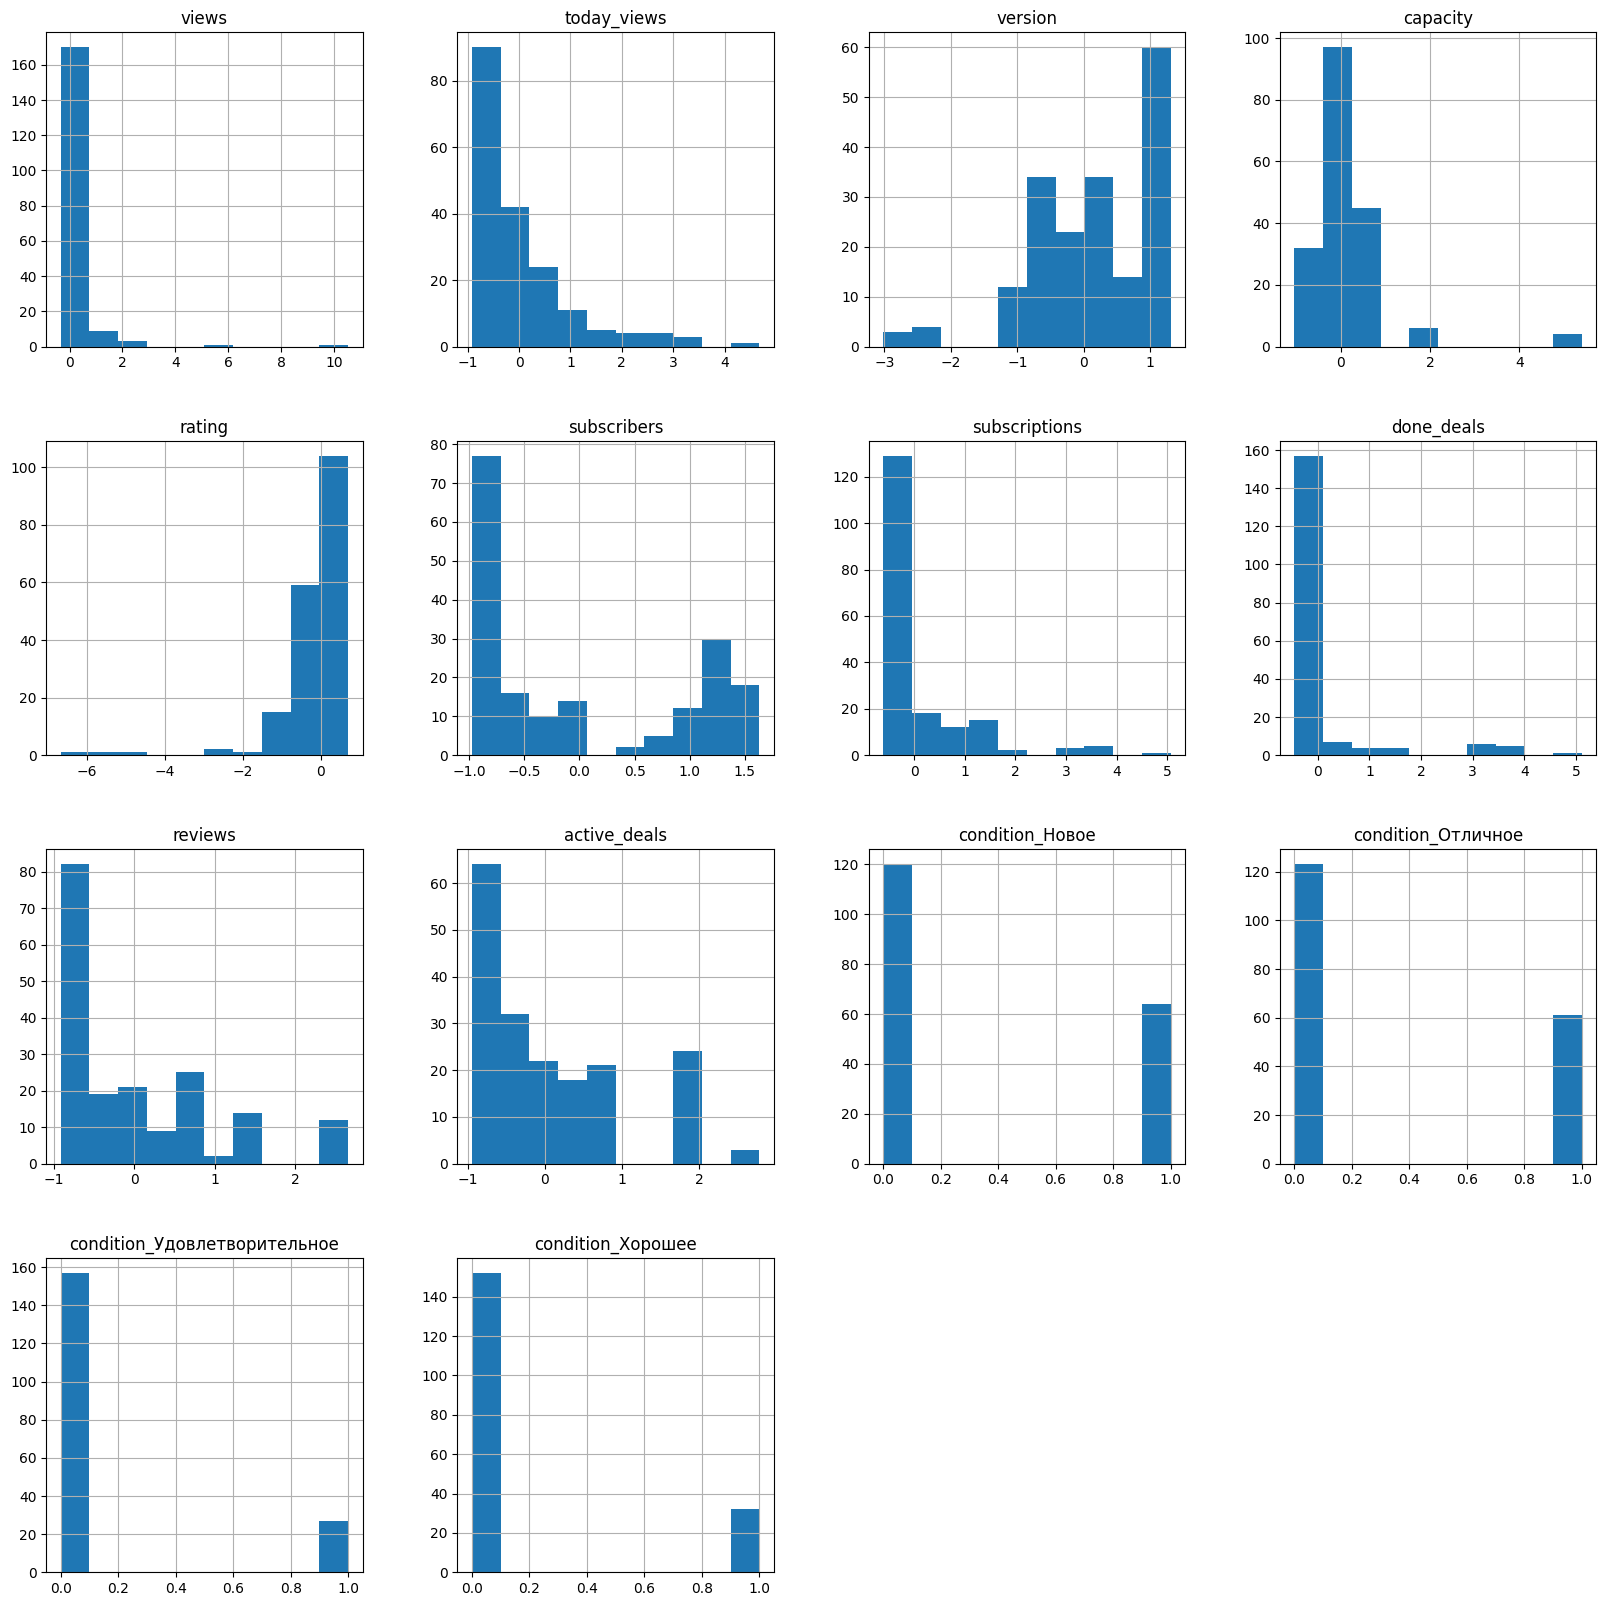

In [66]:
# Convert X_train back to DataFrame
X_train_df = pd.DataFrame(X_train, columns=num_columns.tolist() + transformer.named_transformers_['cat'].get_feature_names_out(cat_features).tolist())
X_train_df.hist(figsize=(20, 20))

<Axes: >

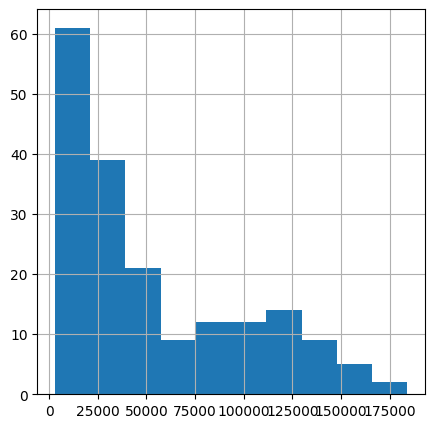

In [67]:
y_train.hist(figsize=(5, 5))